# Milestone 3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

df_plot = pd.read_csv("data/MovieSummaries/plot_summaries.txt", sep='\t', header=None, 
    names=["wikiID", "plot"])
df_meta = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", sep='\t', header=None, 
    names=["wikiID", "freeID", "name", "release_date", "revenue", "runtime", "languages", 
           "countries", "genres"])
df_char = pd.read_csv("data/MovieSummaries/character.metadata.tsv", sep='\t',header=None, 
    names=["WikiID", "freeID", "release_date", "char_name", "actor_DOB", "actor_gender", 
           "actor_height", "actor_ethnicity", "actor_name", "Actor_age", "freeID_char_map", 
           "FreeID_char", "FreeID_actor"])
df_char_names = pd.read_csv('data/MovieSummaries/name.clusters.txt', sep="\t", header=None, 
    names=["char_name", "freeID_char_map"])

df_meta['release_date'] = pd.to_datetime(df_meta['release_date'], errors = 'coerce')
dfull = df_meta.merge(df_plot, how='inner', on="wikiID")

df_char_list = df_char[['freeID','char_name']].groupby('freeID')['char_name'].apply(
    list).reset_index(name='characters')

df_actor_list = df_char[['freeID','actor_name']].groupby('freeID')['actor_name'].apply(
    list).reset_index(name='actors')

df_clean = (dfull[(dfull['genres'] != '{}') & (dfull['plot'].apply(lambda s: len(s.split())) > 10)]
           ).drop(columns=['revenue'])

df_clean['countries'] = pd.DataFrame(data={'countries': df_clean['countries'].apply(lambda x: set(json.loads(x).values()))})
df_clean['languages'] = pd.DataFrame(data={'languages': df_clean['languages'].apply(lambda x: set(json.loads(x).values()))})
df_clean['genres'] = pd.DataFrame(data={'genres': df_clean['genres'].apply(lambda x: set(json.loads(x).values()))}) 

df_clean['release_date'] = df_clean['release_date'].dt.year.apply(lambda x: int(x) if x == x 
                                                                  else None)
df_clean['runtime'] = df_clean['runtime'].apply(lambda x: 'short' if x <= 40 else 
                                                ('long' if x > 40 else 'unknown'))

df_clean = df_clean.merge(df_char_list, how='inner', on='freeID')
df_clean = df_clean.merge(df_actor_list, how='inner', on='freeID')

df_clean['actors'] =pd.DataFrame(data={'actors': df_clean['actors'].apply(lambda x: set(x))})
df_clean['characters'] =pd.DataFrame(data={'actors': df_clean['actors'].apply(lambda x: set(x))})

df_scrapped = pd.read_csv('scrapped.csv')
df_scrapped.drop(columns = df_scrapped.columns[0], axis = 1, inplace= True)
df_clean = df_clean.join(df_scrapped)

## Graph construction

---
## Methods to study similarities accross chosen attributes

In [2]:
import math
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import gensim

from helpers import * 

from re import sub
from gensim.utils import simple_preprocess
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity
from gensim.models.word2vec import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter

In [5]:
Counter(" ".join(df_clean["name"]).split()).most_common(100)

[('The', 7014),
 ('of', 3284),
 ('the', 3253),
 ('and', 1216),
 ('in', 930),
 ('A', 825),
 ('a', 686),
 ('to', 650),
 ('Love', 496),
 ('Man', 430),
 ('My', 407),
 ('for', 338),
 ('Night', 328),
 ('on', 319),
 ('I', 311),
 ('Story', 253),
 ('You', 244),
 ('&', 236),
 ('2', 231),
 ('Me', 228),
 ('Last', 226),
 ('Life', 213),
 ('from', 212),
 ('Girl', 212),
 ('Little', 204),
 ('Dead', 204),
 ('with', 195),
 ('Time', 194),
 ('Movie', 190),
 ('Black', 186),
 ('One', 183),
 ('Big', 183),
 ('House', 182),
 ('In', 181),
 ('Is', 175),
 ('at', 175),
 ('Day', 174),
 ('La', 162),
 ('New', 152),
 ('City', 147),
 ('Death', 147),
 ('World', 146),
 ('Mr.', 141),
 ('de', 137),
 ('King', 135),
 ('All', 134),
 ('Christmas', 133),
 ('Blood', 132),
 ('Two', 132),
 ('Men', 132),
 ('Red', 131),
 ('White', 130),
 ('Woman', 128),
 ('Out', 128),
 ('Three', 128),
 ('It', 127),
 ('No', 124),
 ('2:', 123),
 ('Lost', 123),
 ('Dark', 122),
 ('On', 121),
 ('Secret', 120),
 ('High', 119),
 ('Great', 118),
 ('Lady', 11

In [7]:
stopwords_headlines=['the','of','the','and','in','a','to','my','for','on','&','from']    

Example cosine similarities between 8 movie titles: 
 [[1.         0.22246352 0.36989777 0.21369089 0.         0.
  0.         0.        ]
 [0.22246352 1.         0.         0.         0.         0.
  0.         0.23155467]
 [0.36989777 0.         1.         0.37771231 0.26412931 0.
  0.         0.        ]
 [0.21369089 0.         0.37771231 1.         0.35750701 0.
  0.         0.        ]
 [0.         0.         0.26412931 0.35750701 1.         0.41436966
  0.32194353 0.        ]
 [0.         0.         0.         0.         0.41436966 1.
  0.26680726 0.        ]
 [0.         0.         0.         0.         0.32194353 0.26680726
  1.         0.        ]
 [0.         0.23155467 0.         0.         0.         0.
  0.         1.        ]]
Similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:
0 	 1.0 	 Harry Potter and the Chamber of Secrets
2 	 0.3698977695631081 	 Harry Potter and the Half-Blood Prince
1 	 0.2224635241559541 	 Gnomes

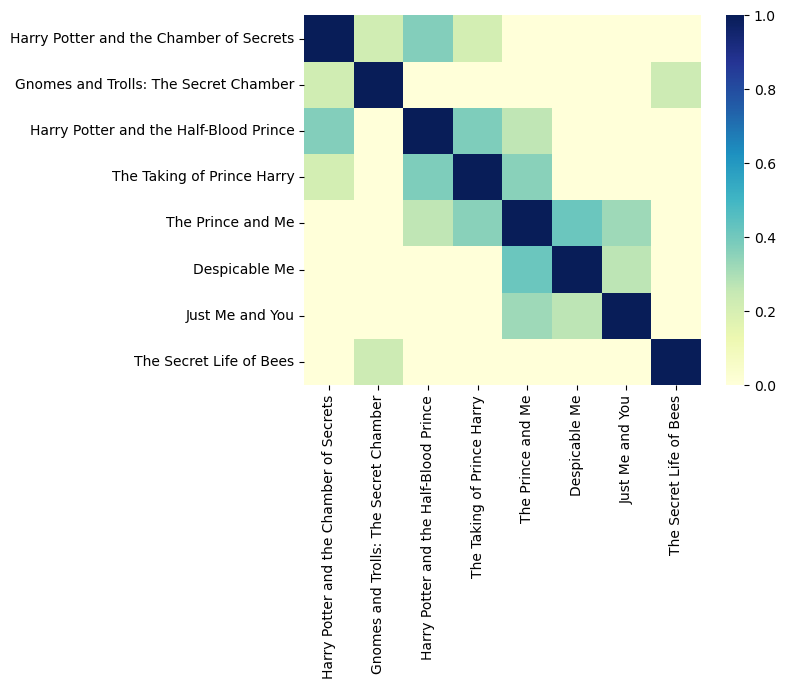

In [8]:
list1= 'Harry Potter and the Chamber of Secrets'
list2= 'Gnomes and Trolls: The Secret Chamber'
list3= 'Harry Potter and the Half-Blood Prince'
list4= 'The Taking of Prince Harry'
list5= 'The Prince and Me'
list6= 'Despicable Me'
list7= 'Just Me and You'
list8= 'The Secret Life of Bees'
headlines = [list1,list2,list3,list4,list5,list6,list7,list8]

def create_heatmap(similarity, labels, cmap = "YlGnBu"):
    df = pd.DataFrame(similarity)
    df.columns = labels
    df.index = labels
    fig, ax = plt.subplots()
    sns.heatmap(df, cmap=cmap)

testsimilarity = headlines_similarity(headlines, stopwords_headlines)
print("Example cosine similarities between 8 movie titles: \n", testsimilarity)

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(testsimilarity[0])[::-1]
print("Similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:")
for idx in sorted_indexes:
    print(idx,'\t', testsimilarity[0,idx],'\t', headlines[idx])

create_heatmap(testsimilarity, headlines)

#### GloVe algorithm
**Definition**
The `GloVe` algorithm is an opensource standford algorithm that associates similarity between words by obtaining vectors representations for words and by mapping them into a meaningful space.

**Implementation** 
We can apply soft cosine similarity computation to study similarity between texts. The matrix S from the soft cosine definition can be calculated with the library `GenSim` and using the `GloVe` algorithm. We would obtain a dataset containing a vector for all the words in our corpus and we could compute the matrix S associating a similarity matrix to all of these words. Then with the soft cosine similarity we could analyse the similarity between the documents in our corpus. 

**Movie Attribute similarity that can be studied**
- Title

In [10]:
from nltk.corpus import stopwords
from nltk import download
download("stopwords")  # Download stopwords list.

# Load the model: this is a big file, can take a while to download and open
glove = api.load('glove-wiki-gigaword-50') 
#glove = api.load('text8')  # download the corpus and return it opened as an iterable

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leond\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stopwords_headlines=['the','of','the','and','in','a','to','my','for','on','&','from']
similarity_index = compute_similarity_index('glove-wiki-gigaword-50') # or 'text8'

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32.48it/s]
C:\Users\leond\anaconda3\lib\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning: divide by zero encountered in divide
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)
C:\Users\leond\anaconda3\lib\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning: invalid value encountered in multiply
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.28it/s]


Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:
0 	 1.0 	 Harry Potter and the Chamber of Secrets
2 	 0.6936235427856445 	 Harry Potter and the Half-Blood Prince
1 	 0.6355619430541992 	 Gnomes and Trolls: The Secret Chamber
3 	 0.4716290831565857 	 The Taking of Prince Harry
4 	 0.4677143096923828 	 The Prince and Me
7 	 0.42917633056640625 	 The Secret Life of Bees
6 	 0.3815200924873352 	 Just Me and You
5 	 0.0 	 Despicable Me
Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:
0 	 1.0 	 Harry Potter and the Chamber of Secrets
2 	 0.6491751074790955 	 Harry Potter and the Half-Blood Prince
1 	 0.5743112564086914 	 Gnomes and Trolls: The Secret Chamber
3 	 0.5569477081298828 	 The Taking of Prince Harry
7 	 0.39027220010757446 	 The Secret Life of Bees
6 	 0.0 	 Just Me and You
5 	 0.0 	 Despicable Me
4 	 0.0 	 The Prince and Me
Soft similarities computed between the

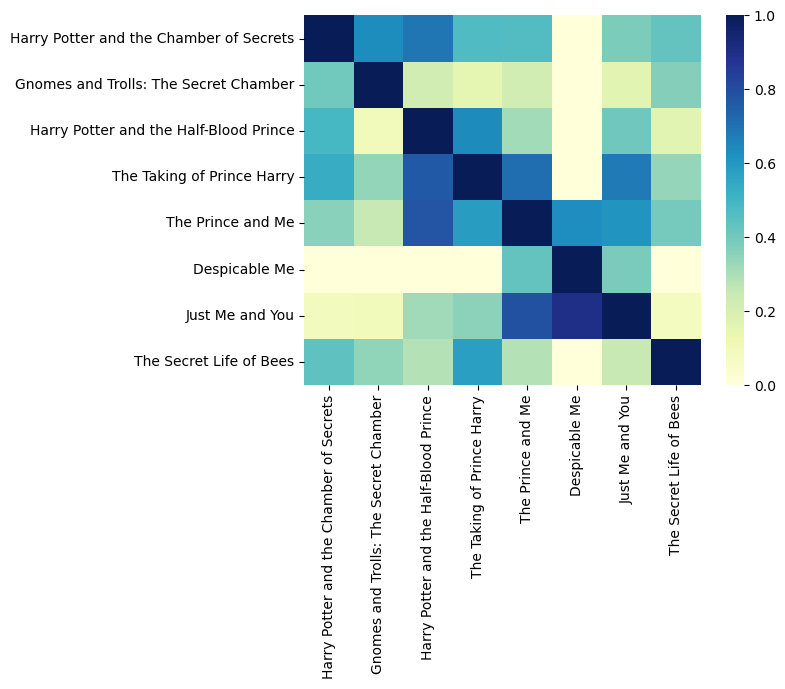

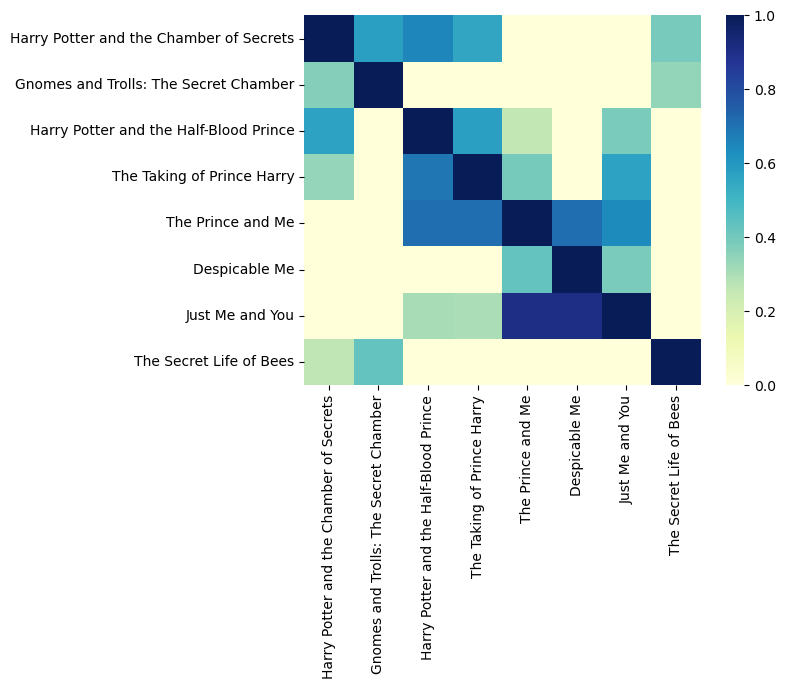

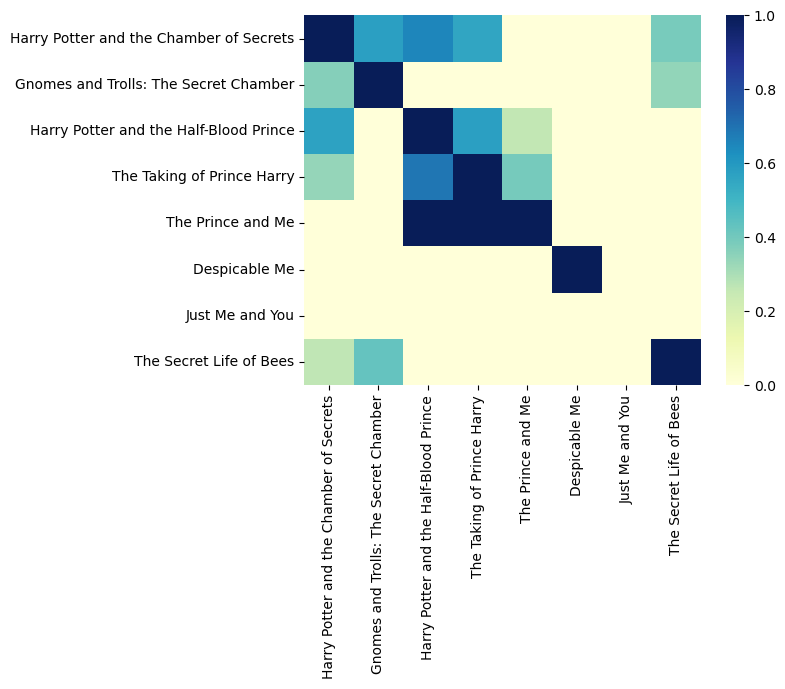

In [12]:
#df_headlines = df_clean['name']
list1= 'Harry Potter and the Chamber of Secrets'
list2= 'Gnomes and Trolls: The Secret Chamber'
list3= 'Harry Potter and the Half-Blood Prince'
list4= 'The Taking of Prince Harry'
list5= 'The Prince and Me'
list6= 'Despicable Me'
list7= 'Just Me and You'
list8= 'The Secret Life of Bees'
headlines = [list1, list2,list3,list4,list5,list6,list7,list8]

stopwords1=[]
test_without_stopwords = headlines_soft_similarity(headlines, stopwords1, similarity_index)

stopwords2=stopwords_headlines
test_few_stopwords = headlines_soft_similarity(headlines, stopwords2, similarity_index)

stopwords3 = set(stopwords.words("english"))
test_full_stopwords = headlines_soft_similarity(headlines, stopwords3, similarity_index)

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(test_without_stopwords[0])[::-1]
print("Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:")
for idx in sorted_indexes:
    print(idx,'\t', test_without_stopwords[0,idx],'\t',headlines[idx])

create_heatmap(test_without_stopwords,headlines)

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(test_few_stopwords[0])[::-1]
print("Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:")
for idx in sorted_indexes:
    print(idx,'\t', test_few_stopwords[0,idx],'\t',headlines[idx])

create_heatmap(test_few_stopwords,headlines)

sorted_indexes = np.argsort(test_full_stopwords[0])[::-1]
print("Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:")
for idx in sorted_indexes:
    print(idx,'\t', test_full_stopwords[0,idx],'\t',headlines[idx])

create_heatmap(test_full_stopwords,headlines)

In [13]:
stopwords_headlines=['the','of','the','and','in','a','to','my','for','on','&','from']
similarity_index = compute_similarity_index('glove-wiki-gigaword-50')

In [14]:
sub_df = df_clean.loc[200:230]
sub_df.reset_index(drop=True,inplace=True)
sub_df.head(10)
sim_dict, ID_vect = similarity_fct(df=sub_df)

stockage_created


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.00it/s]
C:\Users\leond\anaconda3\lib\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning: divide by zero encountered in divide
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)
C:\Users\leond\anaconda3\lib\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning: invalid value encountered in multiply
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)


On veut pas de NAn dans les similarity matrixes

In [15]:
for index, (key, value) in enumerate(sim_dict.items()):
    print('NaN count for',key,'similarity matrix is', np.count_nonzero(np.isnan(value)))
    print(value.shape)

NaN count for genre similarity matrix is 0
(31, 31)
NaN count for language similarity matrix is 0
(31, 31)
NaN count for countries similarity matrix is 0
(31, 31)
NaN count for date similarity matrix is 0
(31, 31)
NaN count for actors similarity matrix is 0
(31, 31)
NaN count for characters similarity matrix is 0
(31, 31)
NaN count for director similarity matrix is 0
(31, 31)
NaN count for color similarity matrix is 0
(31, 31)
NaN count for runtime similarity matrix is 0
(31, 31)
NaN count for headlines similarity matrix is 0
(31, 31)
NaN count for headlines_soft similarity matrix is 0
(31, 31)


Similarity matrix te une seule similarité (ici le genre)

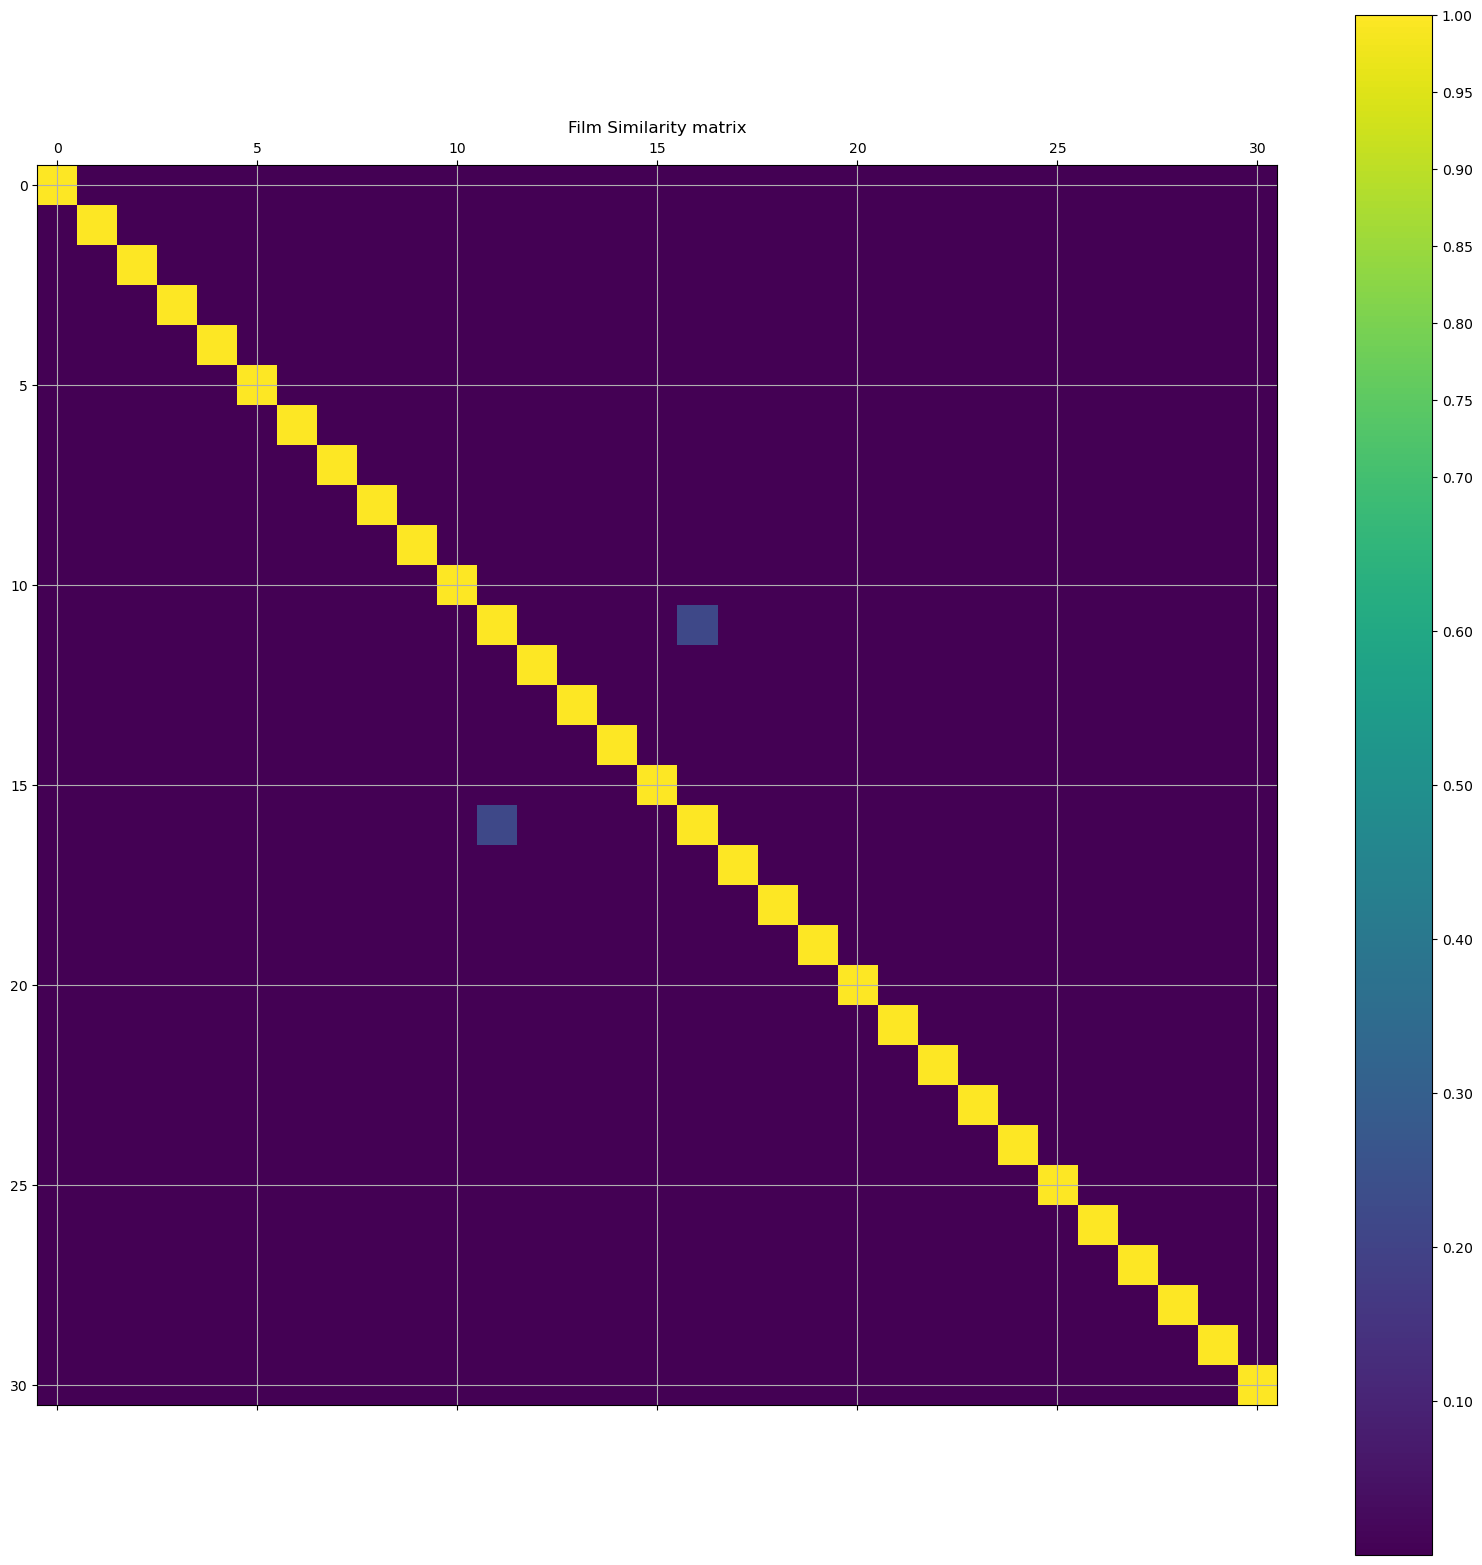

In [16]:
import matplotlib.pyplot as plt
  
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(sim_dict['headlines'], interpolation='nearest')
ax.grid(True)
plt.title('Film Similarity matrix')
# plt.xticks(range(len(sub_df)), ID_vect, rotation=90)
# plt.yticks(range(len(sub_df)), ID_vect)
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

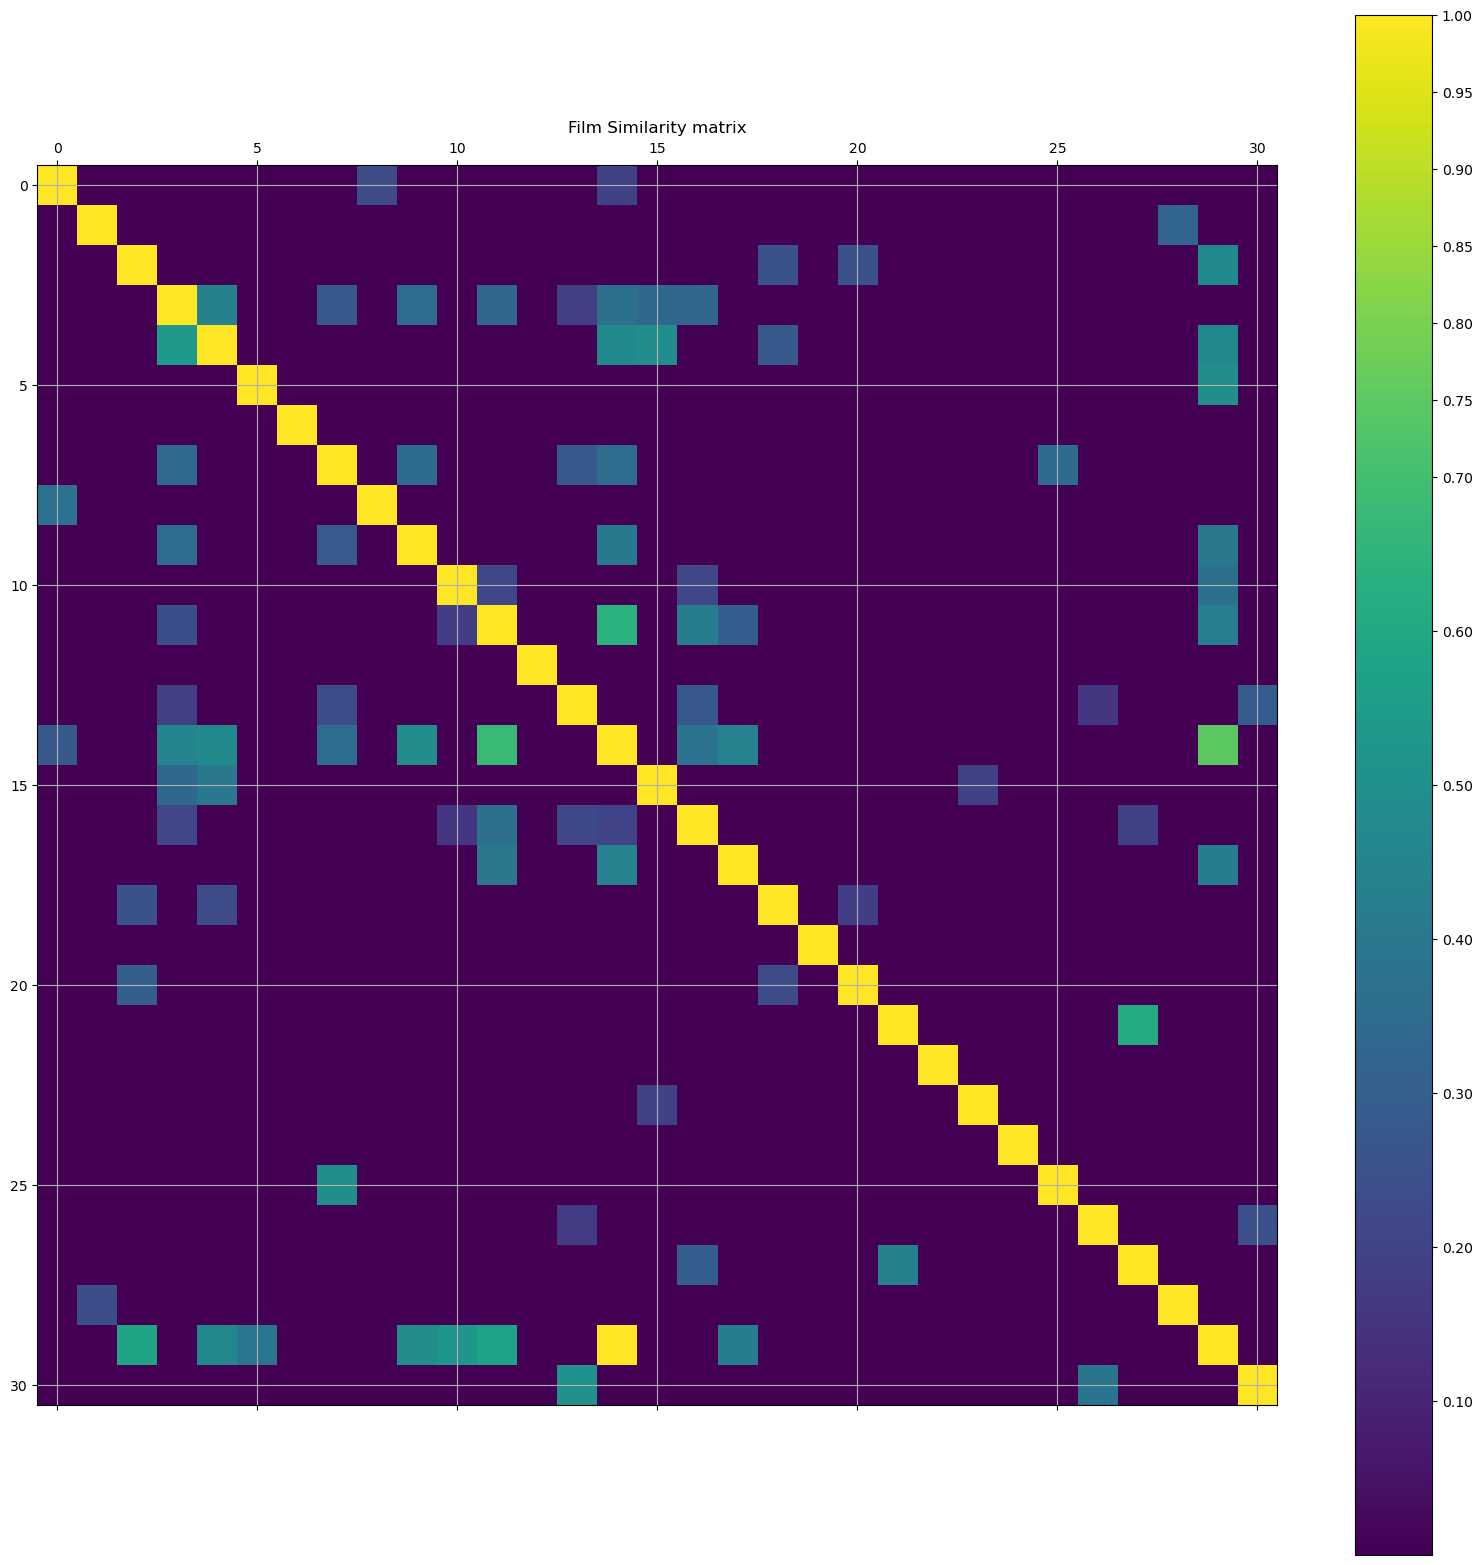

In [17]:
import matplotlib.pyplot as plt
  
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(sim_dict['headlines_soft'], interpolation='nearest')
ax.grid(True)
plt.title('Film Similarity matrix')
# plt.xticks(range(len(sub_df)), ID_vect, rotation=90)
# plt.yticks(range(len(sub_df)), ID_vect)
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

Similarity matrix with weight (not yet normalized, not all similarites yet)

In [18]:
print(len(sim_dict))
w = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
w_norm = w / np.sum(w)
print(w_norm)
sim_matrix = np.zeros(sim_dict['language'].shape)

for index, (key, value) in enumerate(sim_dict.items()):
    sim_matrix = sim_matrix + w_norm[index]*value


11
[0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]


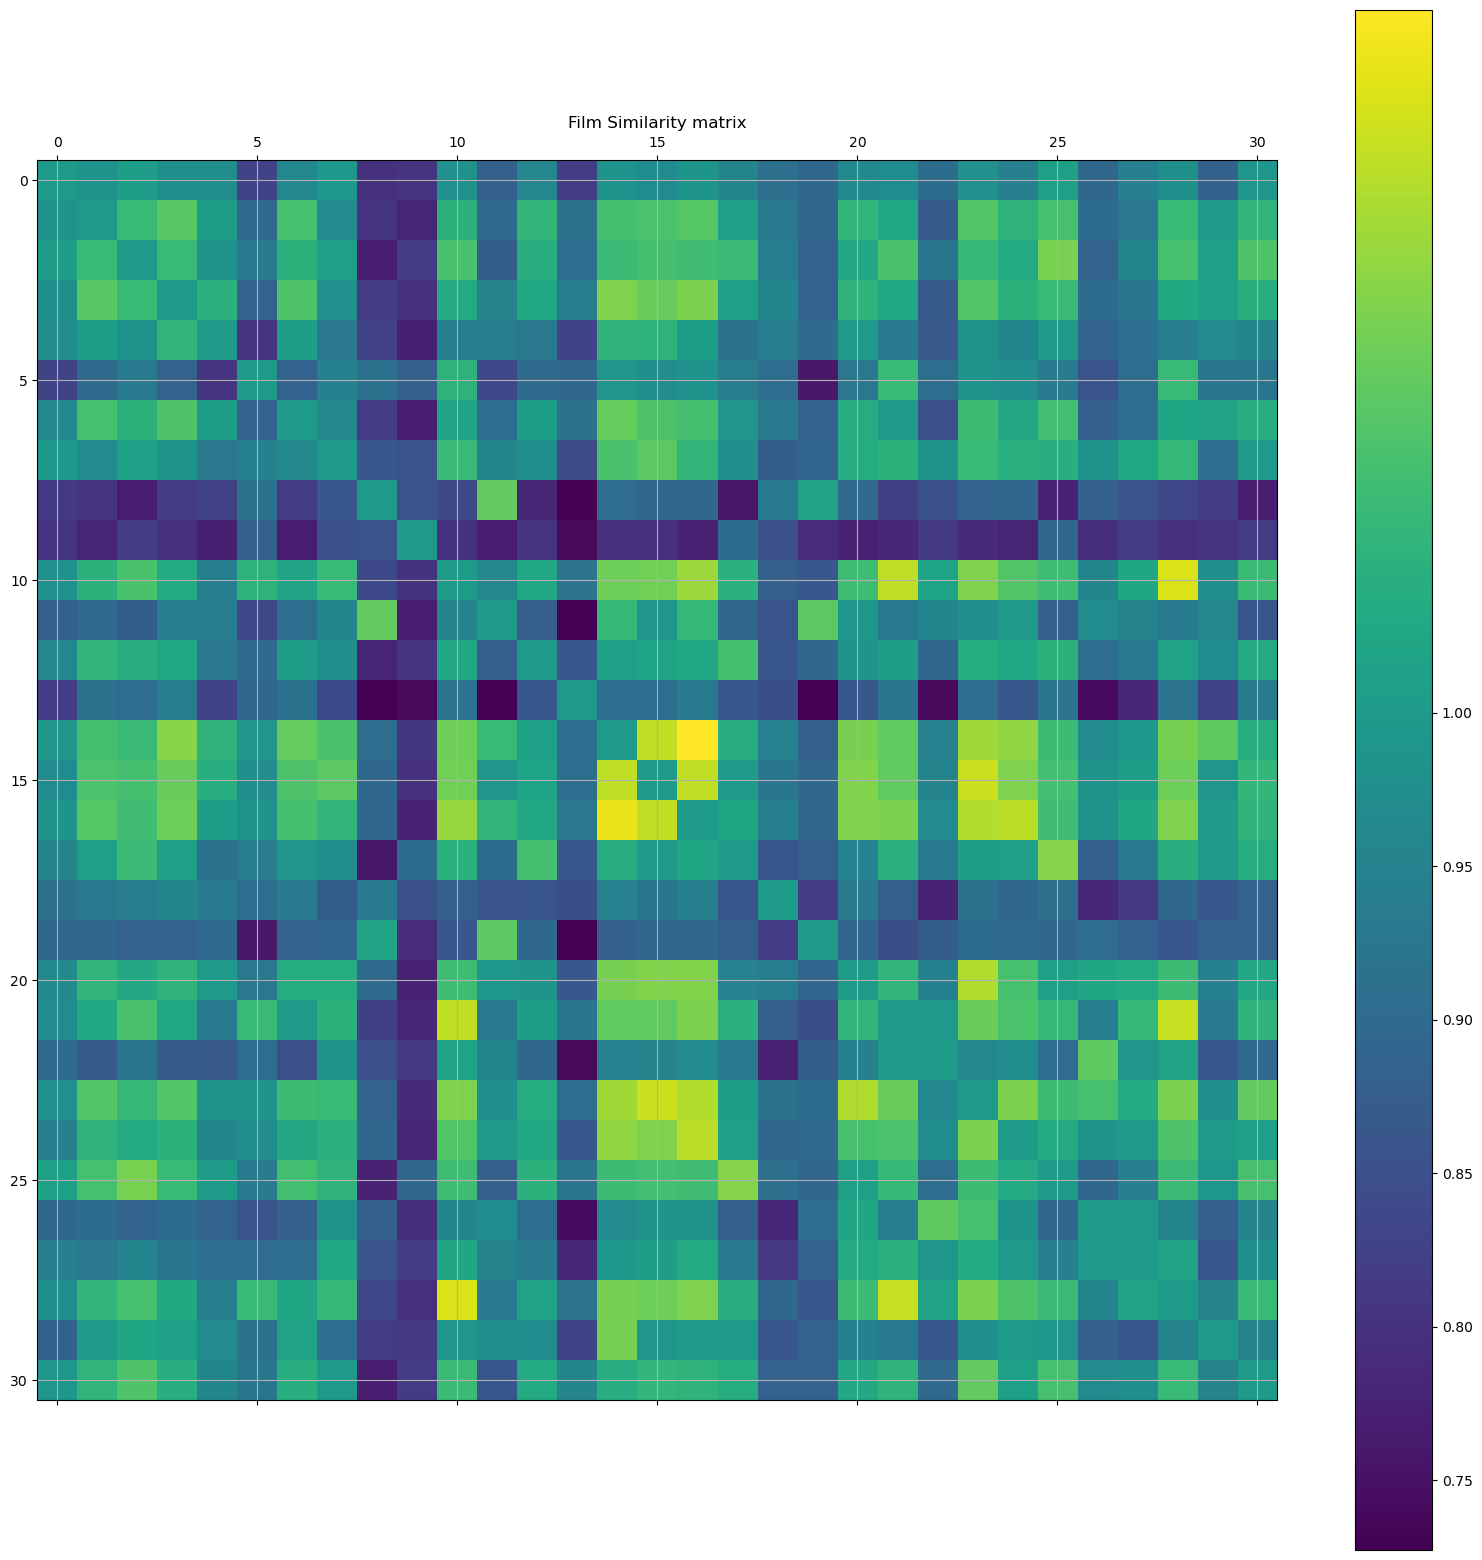

In [19]:
import matplotlib.pyplot as plt
  
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(sim_matrix, interpolation='nearest')
ax.grid(True)
plt.title('Film Similarity matrix')
# plt.xticks(range(len(sub_df)), ID_vect, rotation=90, fontsize=10)
# plt.yticks(range(len(sub_df)), ID_vect, fontsize=10)
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

### 3. Topic extraction method
To compare plots, we will use a topic extraction algorithm. There are a lot that exist, but we will concentrate on three possible: LDA, Doc2Vec and BERTopic.

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
model = BERTopic(vectorizer_model=vectorizer_model, verbose=True, calculate_probabilities=True)
docs = df_plot["plot"].to_list()

topics, probabilities = model.fit_transform(docs)

model.get_topic_freq().head(11)
model.get_topic(0)

df_plot_topics = df_plot.copy()
df_plot_topics = df_plot_topics.drop(["plot"], axis=1)

df_plot_topics = pd.DataFrame(model.probabilities_)
model.probabilities_.shape[0]
df_plot_topics["wikiID"] = df_plot["wikiID"]

df_plot_topics

In [ ]:
df_plot_topics.to_csv('bertopics.csv')
df_plot_test = pd.read_csv("bertopics.csv", sep=',')
df_plot_test